# Workload-Variant-Autoscaler (WVA) Performance Analysis

This notebook analyzes WVA controller logs to visualize autoscaling behavior, warmup gaps, and SLO compliance.

**Workflow:**
1. Extract metrics from WVA controller logs using the bash script
2. Load and process the CSV data
3. Detect scaling phases and warmup gaps
4. Visualize performance metrics and scaling behavior
5. Perform statistical analysis

## 1. Setup and Configuration

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
import subprocess
from pathlib import Path
from datetime import datetime
import os

# Plotting style
plt.style.use('seaborn-v0_8')
%matplotlib inline

# X-axis granularity configuration (in minutes)
X_MAJOR_TICK_INTERVAL = 1.0  # Major tick every 1 minute
X_MINOR_TICK_INTERVAL = 0.5  # Minor tick every 0.5 minutes (30 seconds)

# Configuration
LOG_DIR = f'./txt_logs'
LOG_FILE = f'{LOG_DIR}/ttft_contextaware_scorers_logs.txt'  # Change this to your log file
EXTRACT_SCRIPT = './extract_metrics.sh'

# Generate unique experiment directory based on timestamp
EXPERIMENT_NAME = datetime.now().strftime('%Y%m%d_%H%M%S')
EXPERIMENT_DIR = f'experiments/{EXPERIMENT_NAME}'
OUTPUT_CSV = f'{EXPERIMENT_DIR}/extracted_metrics.csv'

# Create experiment directory structure
os.makedirs(f'{EXPERIMENT_DIR}/plots', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/data', exist_ok=True)
os.makedirs(f'{EXPERIMENT_DIR}/analysis', exist_ok=True)

print(f"✅ Configuration loaded")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Experiment directory: {EXPERIMENT_DIR}")
print(f"   Log file: {LOG_FILE}")
print(f"   Extract script: {EXTRACT_SCRIPT}")
print(f"   Output CSV: {OUTPUT_CSV}")

✅ Configuration loaded
   Experiment: 20251020_150851
   Experiment directory: experiments/20251020_150851
   Log file: ./txt_logs/ttft_contextaware_scorers_logs.txt
   Extract script: ./extract_metrics.sh
   Output CSV: experiments/20251020_150851/extracted_metrics.csv


**📊 X-Axis Granularity Settings:**
- **Major ticks** (bold lines with labels): Every **0.5 minutes** (30 seconds)
- **Minor ticks** (light grid lines): Every **0.1 minutes** (6 seconds)

💡 *To adjust granularity, change `X_MAJOR_TICK_INTERVAL` and `X_MINOR_TICK_INTERVAL` above:*
- For **coarser** view: Use 1.0 (major) and 0.5 (minor) for 1-minute intervals
- For **finer** view: Use 0.25 (major) and 0.05 (minor) for 15-second intervals
- For **very fine** view: Use 0.1 (major) and 0.02 (minor) for 6-second intervals

## 2. Extract Metrics from Logs

Run the bash script to parse the WVA controller logs and extract optimization metrics.

In [97]:
# Make the script executable
!chmod +x {EXTRACT_SCRIPT}

# Run the extraction script
print(f"📊 Extracting metrics from {LOG_FILE}...")
result = subprocess.run(
    [EXTRACT_SCRIPT, LOG_FILE],
    capture_output=True,
    text=True
)

# Save to CSV
with open(OUTPUT_CSV, 'w') as f:
    f.write(result.stdout)

print(f"✅ Metrics extracted to {OUTPUT_CSV}")
print(f"   Lines extracted: {len(result.stdout.splitlines())}")

# Preview the first few lines
print("\n📋 Preview of extracted data:")
!head -5 {OUTPUT_CSV}

📊 Extracting metrics from ./txt_logs/ttft_contextaware_scorers_logs.txt...
✅ Metrics extracted to experiments/20251020_150851/extracted_metrics.csv
   Lines extracted: 109

📋 Preview of extracted data:
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft
2025-10-20T17:07:56.177Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:07:56.195Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:08:56.198Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:08:56.214Z,0,0,0,0,0,1,7.514,15.415337,9,1000
timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft
2025-10-20T17:07:56.177Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:07:56.195Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:08:56.198Z,0,0,0,0,0,1,7.514,15.415337,9,1000
2025-10-20T17:08:56.214Z,0,0,0,0,0,1,7.514,15.415337,9,1000


## 3. Load and Process Data

### 3.1 Diagnostics (Run if you get errors)

In [98]:
print("🔍 Diagnosing extraction issue...\n")

# 1. Check log file
print(f"1. Log file check:")
log_path = LOG_FILE
BASH_SCRIPT = EXTRACT_SCRIPT
if os.path.exists(log_path):
    size = os.path.getsize(log_path)
    print(f"   ✓ File exists: {log_path}")
    print(f"   ✓ Size: {size:,} bytes")
    
    # Sample first few lines
    print(f"\n   First 5 lines of log file:")
    with open(log_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= 5:
                break
            print(f"   {i+1}: {line[:100]}...")
else:
    print(f"   ✗ File not found: {log_path}")

# 2. Check CSV output
print(f"\n2. CSV output check:")
if os.path.exists(OUTPUT_CSV):
    size = os.path.getsize(OUTPUT_CSV)
    print(f"   ✓ File exists: {OUTPUT_CSV}")
    print(f"   ✓ Size: {size:,} bytes")
    
    if size > 0:
        # Read CSV and show structure
        df_test = pd.read_csv(OUTPUT_CSV)
        print(f"   ✓ Rows: {len(df_test)}")
        print(f"   ✓ Columns: {list(df_test.columns)}")
        
        if len(df_test) > 0:
            print(f"\n   First row:")
            print(df_test.head(1).to_string())
        else:
            print(f"   ✗ CSV has no data rows (only headers)")
    else:
        print(f"   ✗ CSV is empty (0 bytes)")
else:
    print(f"   ✗ File not found: {OUTPUT_CSV}")

# 3. Check for JSON patterns in log file
print(f"\n3. Log format check:")
if os.path.exists(log_path):
    with open(log_path, 'r') as f:
        content = f.read()
        
    # Look for expected patterns
    has_optimization = 'optimizationMetrics' in content
    has_itl = 'itlAverage' in content or '"itl"' in content
    has_ttft = 'ttftAverage' in content or '"ttft"' in content
    
    print(f"   optimizationMetrics found: {'✓' if has_optimization else '✗'}")
    print(f"   ITL metrics found: {'✓' if has_itl else '✗'}")
    print(f"   TTFT metrics found: {'✓' if has_ttft else '✗'}")
    
    if not (has_optimization or has_itl):
        print(f"\n   ⚠️  Log file doesn't appear to contain expected metrics.")
        print(f"   Expected format: JSON with 'optimizationMetrics' field")
        print(f"\n   Sample expected format:")
        print(f'   {{"optimizationMetrics":{{"itlAverage":12.5,"ttftAverage":850,"rate":45.2,...}}}}')

print("\n" + "="*70)
print("If you see issues above, check:")
print("  1. Is LOG_FILE pointing to the correct WVA controller log file?")
print("  2. Does the log contain optimizationMetrics JSON entries?")
print("  3. Try running the extraction manually:")
print(f"     {BASH_SCRIPT} {LOG_FILE}")
print("="*70)

🔍 Diagnosing extraction issue...

1. Log file check:
   ✓ File exists: ./txt_logs/ttft_contextaware_scorers_logs.txt
   ✓ Size: 606,112 bytes

   First 5 lines of log file:
   1: {"level":"INFO","ts":"2025-10-20T17:07:39.967Z","msg":"Zap logger initialized"}
...
   2: {"level":"INFO","ts":"2025-10-20T17:07:39.969Z","msg":"Creating metrics emitter instance"}
...
   3: {"level":"INFO","ts":"2025-10-20T17:07:39.969Z","msg":"Metrics emitter created successfully"}
...
   4: {"level":"INFO","ts":"2025-10-20T17:07:39.969Z","msg":"Using Prometheus configuration from environme...
   5: {"level":"WARN","ts":"2025-10-20T17:07:39.969Z","msg":"TLS certificate verification is disabled - th...

2. CSV output check:
   ✓ File exists: experiments/20251020_150851/extracted_metrics.csv
   ✓ Size: 7,733 bytes
   ✓ Rows: 108
   ✓ Columns: ['timestamp', 'itlAverage', 'ttftAverage', 'rate', 'inTk', 'outTk', 'numRep', 'itl', 'ttft', 'slo_itl', 'slo_ttft']

   First row:
                  timestamp  itlAverage

In [99]:
# Load the CSV data
df = pd.read_csv(OUTPUT_CSV)

# Check if data was extracted
if len(df) == 0:
    print("❌ ERROR: No data was extracted from the log file!")
    print("\nPossible issues:")
    print("1. Log file format doesn't match the extraction script")
    print("2. Log file doesn't contain optimization data")
    print("3. Log file path is incorrect")
    print(f"\nLog file: {LOG_FILE}")
    print(f"CSV file: {OUTPUT_CSV}")
    print("\nPlease check:")
    print("- Does the log file exist and have content?")
    print("- Does it contain lines with 'System data prepared for optimization'?")
    print("- Is the extraction script working correctly?")
    print("\nRun this to check the log file:")
    print(f"  !grep -i 'optimization' {LOG_FILE} | head -5")
    raise ValueError("No data extracted - please check log file and extraction script")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Calculate time in minutes from start
df['time_minutes'] = (df['timestamp'] - df['timestamp'].min()).dt.total_seconds() / 60

# Display basic statistics
print("📊 Data Summary:")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Replica range: {df['numRep'].min():.0f} → {df['numRep'].max():.0f}")
print(f"   Load range: {df['rate'].min():.1f} → {df['rate'].max():.1f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

# Display first few rows
print("\n📋 Data preview:")
df.head(10)

📊 Data Summary:
   Duration: 53.0 minutes
   Data points: 108
   Replica range: 1 → 4
   Load range: 0.0 → 1689.8 rpm
   SLO ITL: 9 ms
   SLO TTFT: 1000 ms

📋 Data preview:


,timestamp,itlAverage,ttftAverage,rate,inTk,outTk,numRep,itl,ttft,slo_itl,slo_ttft,time_minutes
0,2025-10-20 17:07:56.177000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,0.000000
1,2025-10-20 17:07:56.195000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,0.000300
2,2025-10-20 17:08:56.198000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,1.000350
3,2025-10-20 17:08:56.214000+00:00,0.00,0.00,0.00,0,0,1,7.514000,15.415337,9,1000,1.000617
4,2025-10-20 17:09:56.263000+00:00,7.70,25.45,0.00,0,0,1,7.514000,15.415337,9,1000,2.001433
5,2025-10-20 17:09:56.302000+00:00,7.70,25.45,0.00,0,0,1,7.514000,15.415337,9,1000,2.002083
6,2025-10-20 17:10:56.299000+00:00,9.82,20.19,407.33,254,458,1,8.708059,17.823532,9,1000,3.002033
7,2025-10-20 17:10:56.349000+00:00,9.82,20.19,407.33,254,458,1,8.708059,17.823532,9,1000,3.002867
8,2025-10-20 17:11:56.329000+00:00,9.49,18.74,401.34,209,465,1,8.708357,17.397299,9,1000,4.002533
9,2025-10-20 17:11:56.370000+00:00,9.49,18.74,401.34,209,465,1,8.708357,17.397299,9,1000,4.003217


## 4. Detect Scaling Events and Warmup Gaps

In [100]:
def detect_scaling_events(df, slo_threshold=None):
    """
    Detect scaling events and warmup gaps where actual TPOT exceeds SLO.
    """
    if slo_threshold is None:
        slo_threshold = df['slo_itl'].iloc[0]
    
    scaling_events = []
    warmup_gaps = []
    
    # Detect replica changes
    for i in range(1, len(df)):
        if df['numRep'].iloc[i] != df['numRep'].iloc[i-1]:
            scaling_events.append({
                'time': df['time_minutes'].iloc[i],
                'from_replicas': df['numRep'].iloc[i-1],
                'to_replicas': df['numRep'].iloc[i],
                'load': df['rate'].iloc[i]
            })
    
    # Detect warmup gaps (TPOT > SLO)
    in_gap = False
    gap_start = None
    
    for i in range(len(df)):
        tpot = df['itlAverage'].iloc[i]
        
        if tpot > slo_threshold and not in_gap:
            # Start of warmup gap
            in_gap = True
            gap_start = i
        elif tpot <= slo_threshold and in_gap:
            # End of warmup gap
            in_gap = False
            warmup_gaps.append({
                'start_time': df['time_minutes'].iloc[gap_start],
                'end_time': df['time_minutes'].iloc[i-1],
                'duration': df['time_minutes'].iloc[i-1] - df['time_minutes'].iloc[gap_start],
                'peak_violation': df['itlAverage'].iloc[gap_start:i].max(),
                'avg_tpot': df['itlAverage'].iloc[gap_start:i].mean(),
                'avg_load': df['rate'].iloc[gap_start:i].mean()
            })
    
    return scaling_events, warmup_gaps

# Detect events
scaling_events, warmup_gaps = detect_scaling_events(df)

print("🔄 Scaling Events Detected:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n⚠️  Warmup Gaps Detected (TPOT > SLO):")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"   {i}. t={gap['start_time']:.1f}-{gap['end_time']:.1f}min ({gap['duration']:.1f}min)")
    print(f"      Peak: {gap['peak_violation']:.2f}ms, Avg: {gap['avg_tpot']:.2f}ms, Load: {gap['avg_load']:.0f} rpm")

🔄 Scaling Events Detected:
   1. t=9.0min: 1 → 2 replicas (load: 803.9 rpm)
   2. t=15.0min: 2 → 4 replicas (load: 1573.8 rpm)
   3. t=21.0min: 4 → 2 replicas (load: 858.6 rpm)
   4. t=27.0min: 2 → 1 replicas (load: 395.0 rpm)

⚠️  Warmup Gaps Detected (TPOT > SLO):
   1. t=3.0-20.0min (17.0min)
      Peak: 12.77ms, Avg: 10.64ms, Load: 957 rpm
   2. t=22.0-26.0min (4.0min)
      Peak: 9.95ms, Avg: 9.74ms, Load: 799 rpm
   3. t=28.0-32.0min (4.0min)
      Peak: 9.94ms, Avg: 9.76ms, Load: 412 rpm


## 5. Visualization: ITL Performance with Warmup Gaps

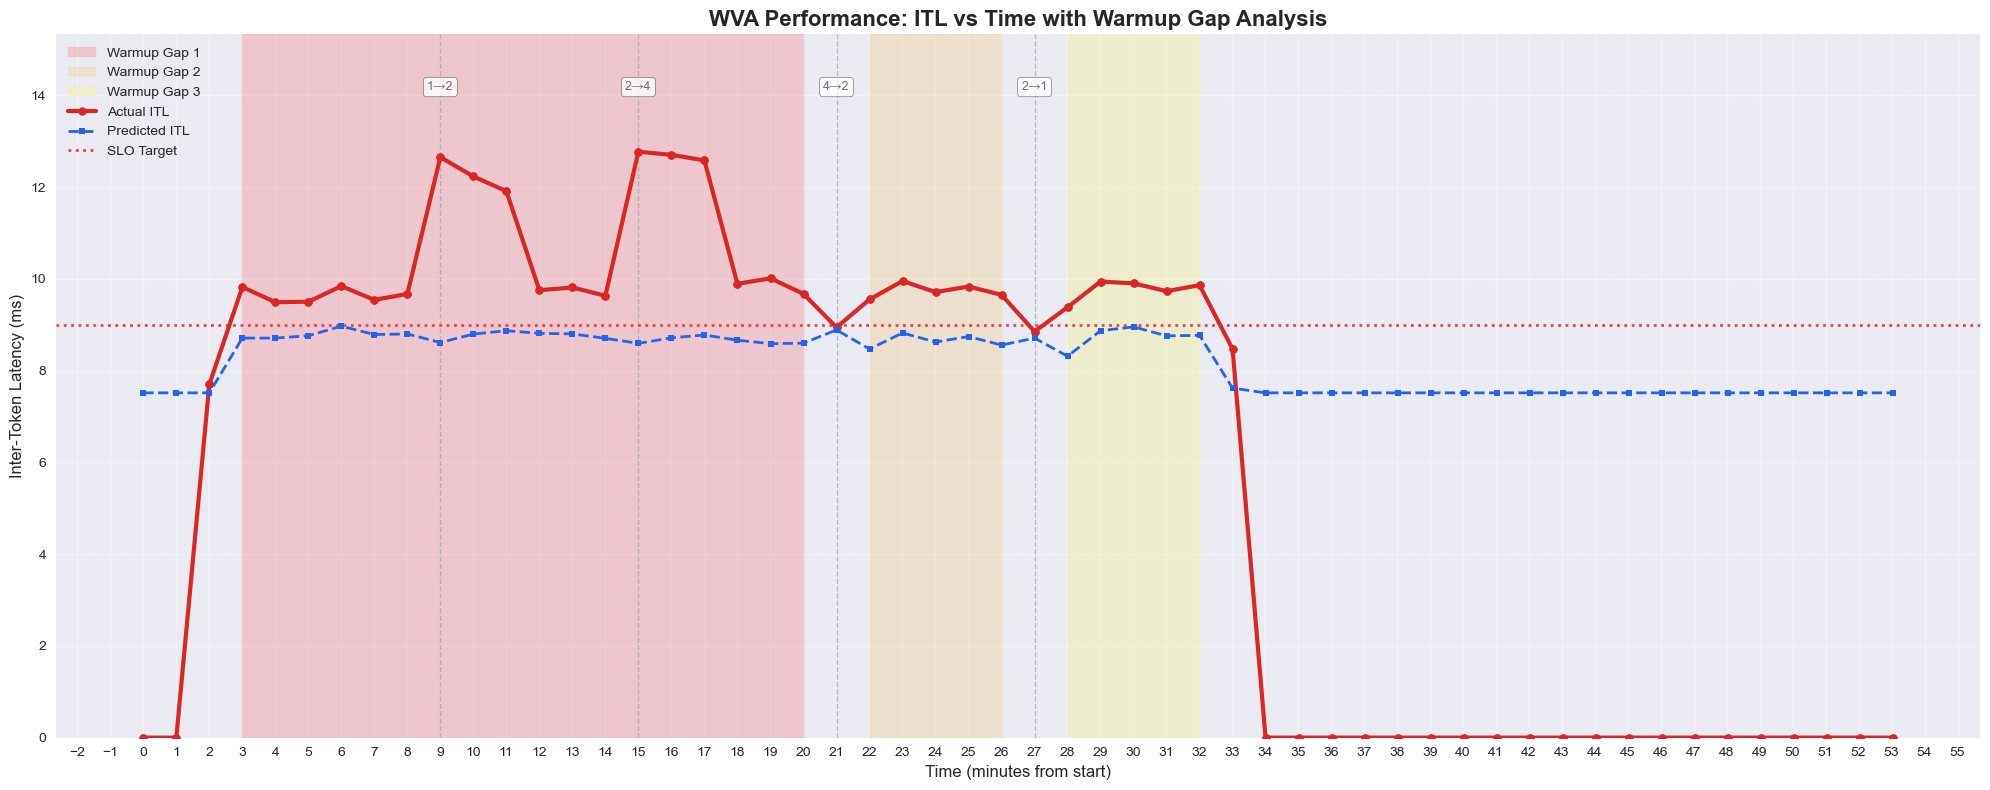

✅ Plot saved as 'experiments/20251020_150851/plots/itl_analysis.png'


In [101]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['itlAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}"
    )
    ax.add_patch(rect)

# Plot ITL metrics
ax.plot(df['time_minutes'], df['itlAverage'], 'o-', 
        linewidth=3, markersize=6, color='#dc2626', 
        label='Actual ITL', zorder=3)
ax.plot(df['time_minutes'], df['itl'], 's--', 
        linewidth=2, markersize=4, color='#2563eb', 
        label='Predicted ITL', zorder=3)
ax.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['itlAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax.set_title('WVA Performance: ITL vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['itlAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

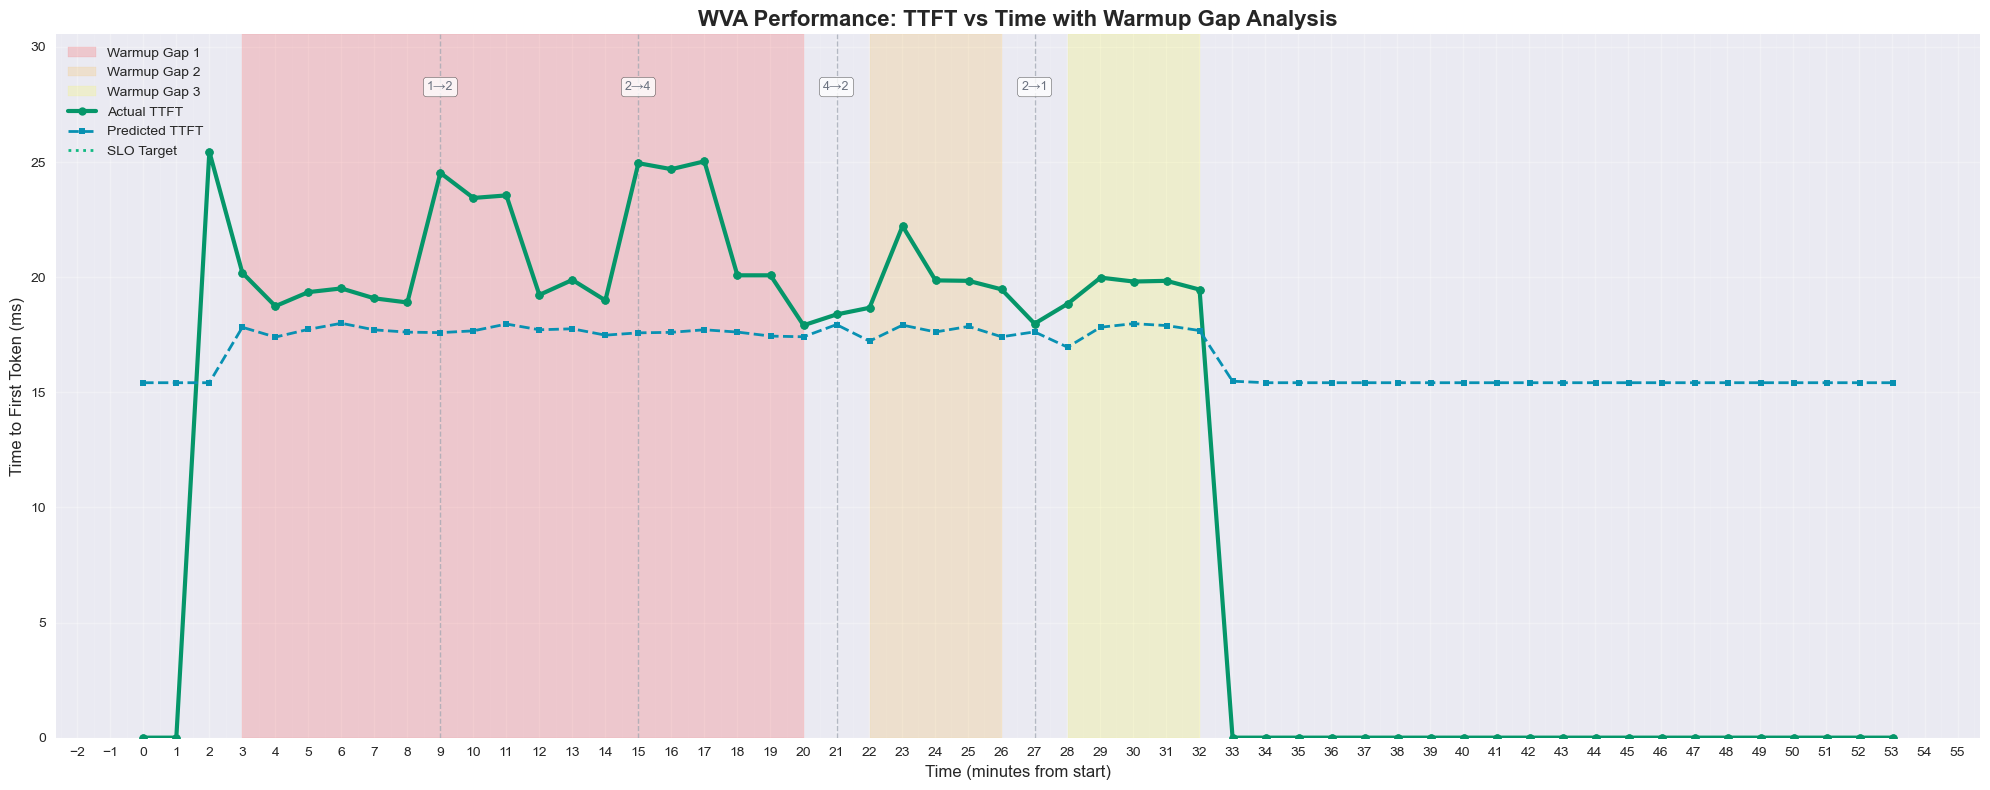

✅ Plot saved as 'experiments/20251020_150851/plots/ttft_analysis.png'


In [102]:
fig, ax = plt.subplots(figsize=(20, 8))

# Highlight warmup gaps
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['ttftAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}"
    )
    ax.add_patch(rect)

# Plot TTFT metrics
ax.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
        linewidth=3, markersize=6, color='#059669', 
        label='Actual TTFT', zorder=3)
ax.plot(df['time_minutes'], df['ttft'], 's--', 
        linewidth=2, markersize=4, color='#0891b2', 
        label='Predicted TTFT', zorder=3)
ax.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
           linestyle=':', linewidth=2, label='SLO Target', zorder=2)

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#9ca3af', 
               linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax.text(event['time'], df['ttftAverage'].max() * 1.1, 
            f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='bottom', fontsize=9, color='#6b7280',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax.set_xlabel('Time (minutes from start)', fontsize=12)
ax.set_ylabel('Time to First Token (ms)', fontsize=12)
ax.set_title('WVA Performance: TTFT vs Time with Warmup Gap Analysis', 
             fontweight='bold', fontsize=16)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_analysis.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 6. Visualization: TTFT Performance with Warmup Gaps

## 7. Visualization: Load Pattern Evolution

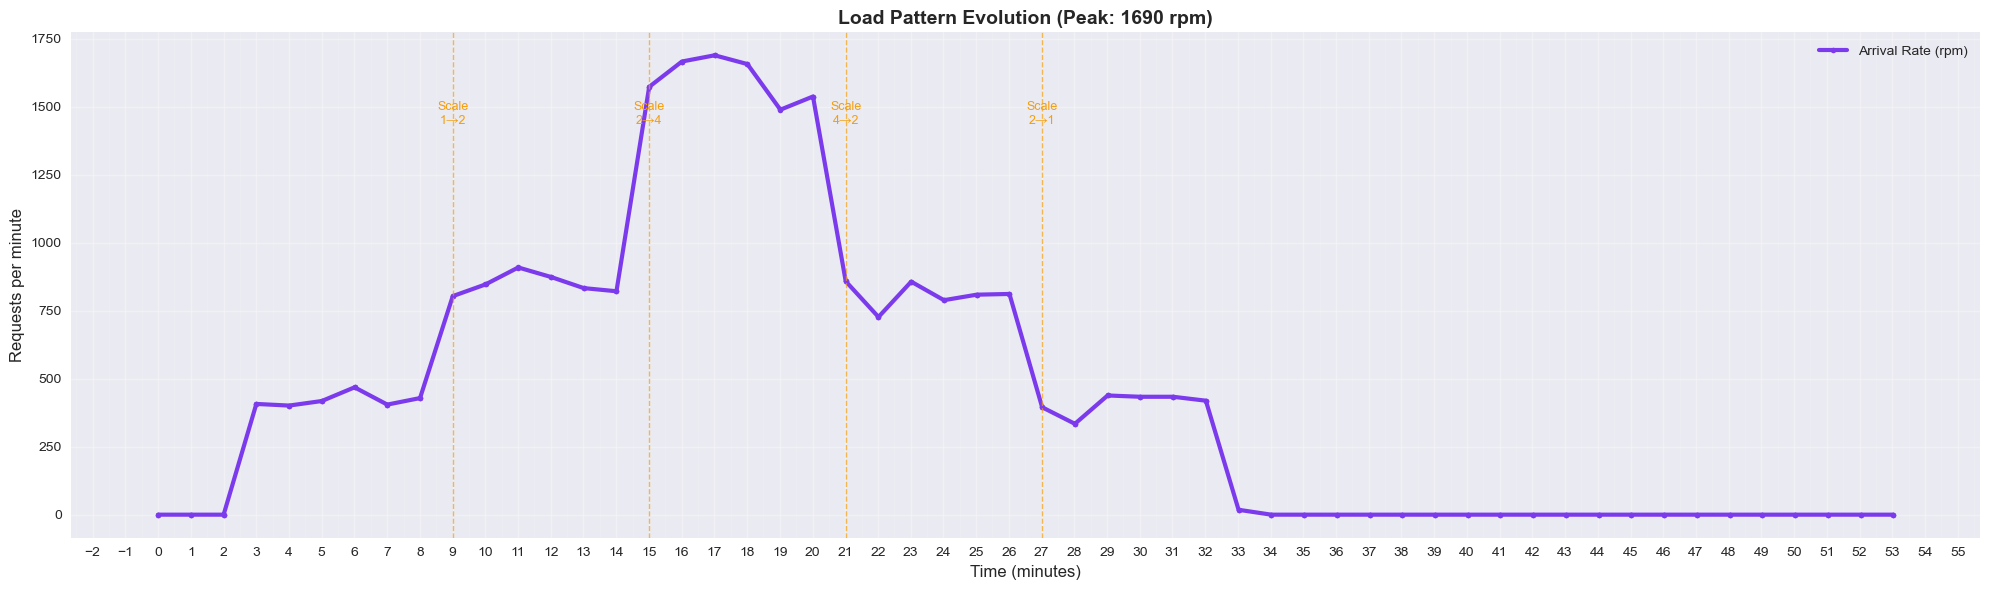

✅ Plot saved as 'experiments/20251020_150851/plots/load_pattern.png'


In [103]:
fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(df['time_minutes'], df['rate'], 'o-', 
        linewidth=3, markersize=4, color='#7c3aed', 
        label='Arrival Rate (rpm)')

# Mark scaling events
for event in scaling_events:
    ax.axvline(x=event['time'], color='#f59e0b', 
               linestyle='--', alpha=0.7, linewidth=1)
    ax.text(event['time'], df['rate'].max() * 0.9,
            f"Scale\n{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
            ha='center', va='top', fontsize=9, color='#f59e0b')

ax.set_xlabel('Time (minutes)', fontsize=12)
ax.set_ylabel('Requests per minute', fontsize=12)
ax.set_title(f"Load Pattern Evolution (Peak: {df['rate'].max():.0f} rpm)",
             fontweight='bold', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

# Set x-axis granularity
ax.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax.grid(True, which='major', alpha=0.3, linewidth=1)
ax.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/load_pattern.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 8. Visualization: ITL vs Replica Scaling Timeline

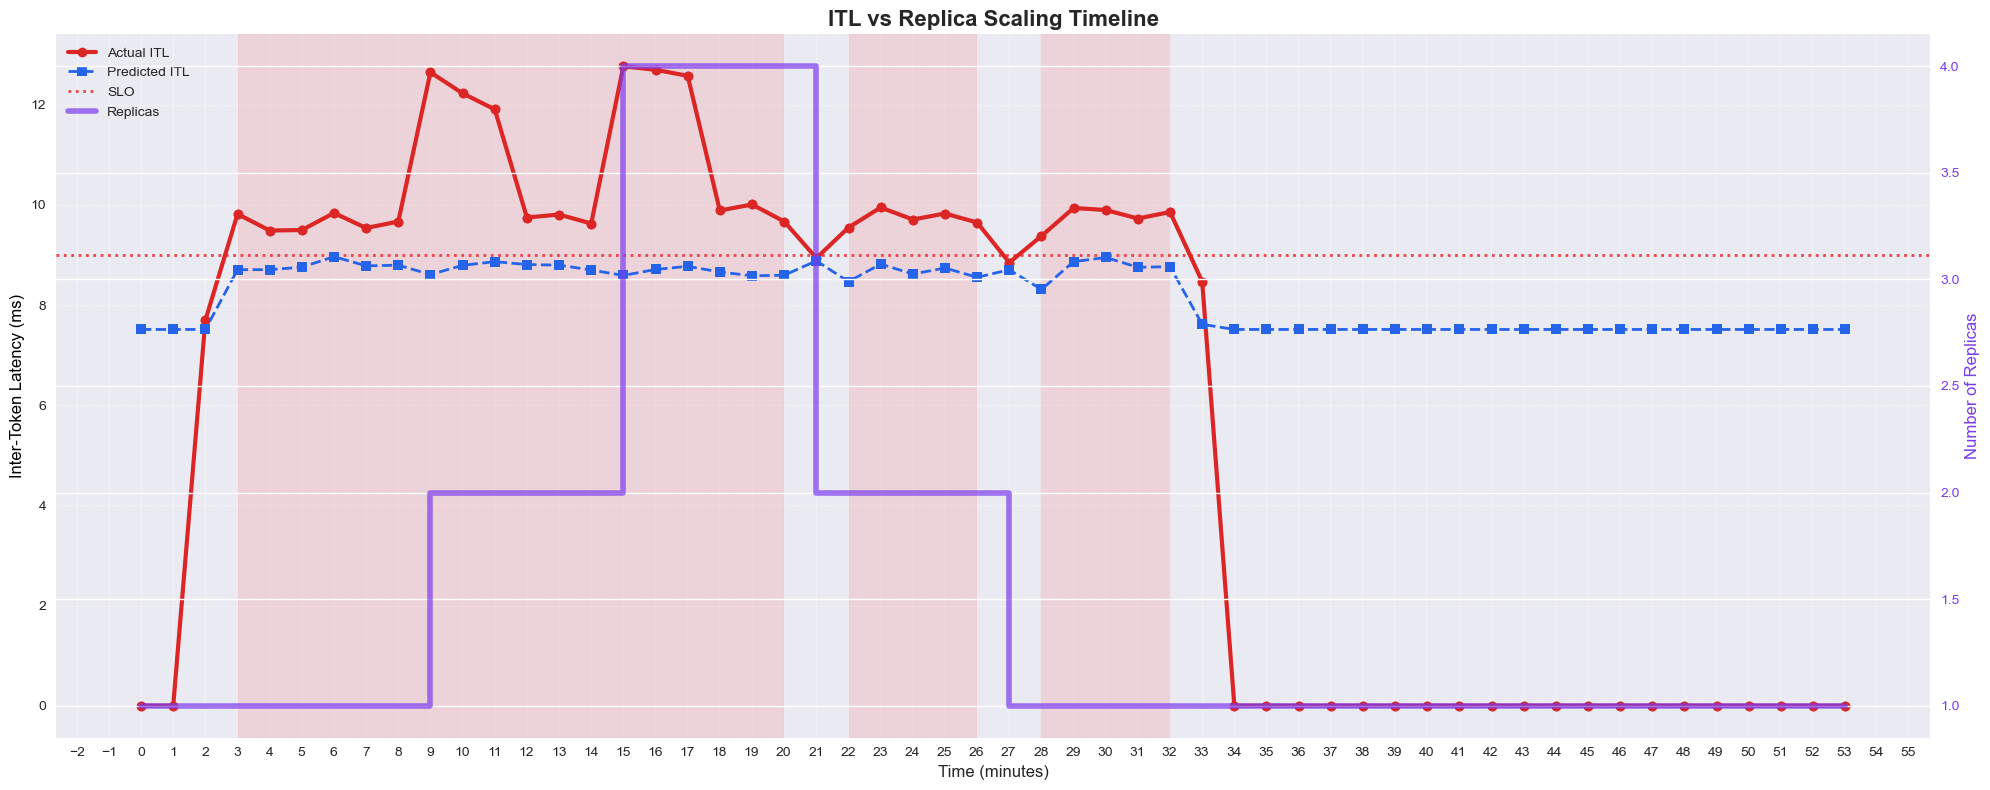

✅ Plot saved as 'experiments/20251020_150851/plots/itl_replicas_timeline.png'


In [104]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# ITL on left axis
line1 = ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
                 linewidth=3, color='#dc2626', label='Actual ITL', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['itl'], 's--', 
                 linewidth=2, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps
for gap in warmup_gaps:
    ax1.axvspan(gap['start_time'], gap['end_time'], 
                alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Inter-Token Latency (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('ITL vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/itl_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

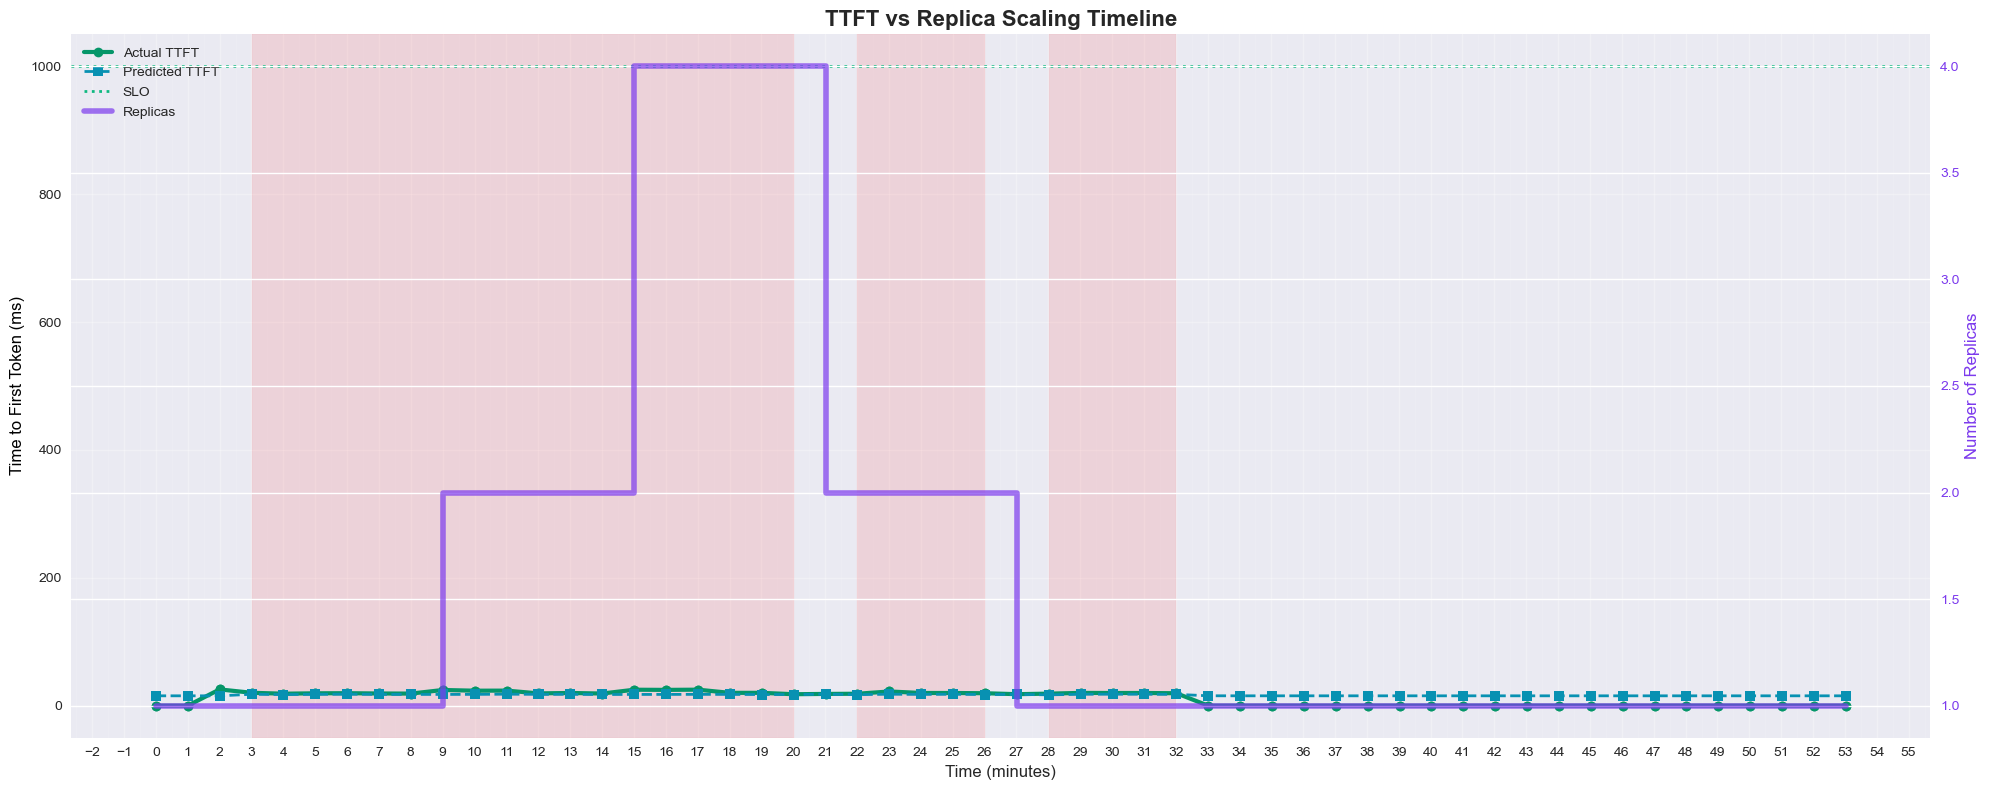

✅ Plot saved as 'experiments/20251020_150851/plots/ttft_replicas_timeline.png'


In [105]:
fig, ax1 = plt.subplots(figsize=(20, 8))
ax2 = ax1.twinx()

# TTFT on left axis
line1 = ax1.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
                 linewidth=3, color='#059669', label='Actual TTFT', zorder=3)
line2 = ax1.plot(df['time_minutes'], df['ttft'], 's--', 
                 linewidth=2, color='#0891b2', label='Predicted TTFT', zorder=3)
ax1.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO')

# Replicas on right axis
line3 = ax2.step(df['time_minutes'], df['numRep'], where='post',
                 linewidth=4, color='#7c3aed', alpha=0.7, label='Replicas')

# Highlight warmup gaps
for gap in warmup_gaps:
    ax1.axvspan(gap['start_time'], gap['end_time'], 
                alpha=0.1, color='red', zorder=1)

ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Time to First Token (ms)', color='black', fontsize=12)
ax2.set_ylabel('Number of Replicas', color='#7c3aed', fontsize=12)
ax2.tick_params(axis='y', labelcolor='#7c3aed')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

ax1.set_title('TTFT vs Replica Scaling Timeline', fontweight='bold', fontsize=16)
ax1.grid(True, alpha=0.3)

# Set x-axis granularity
ax1.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax1.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/ttft_replicas_timeline.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 9. Visualization: TTFT vs Replica Scaling Timeline

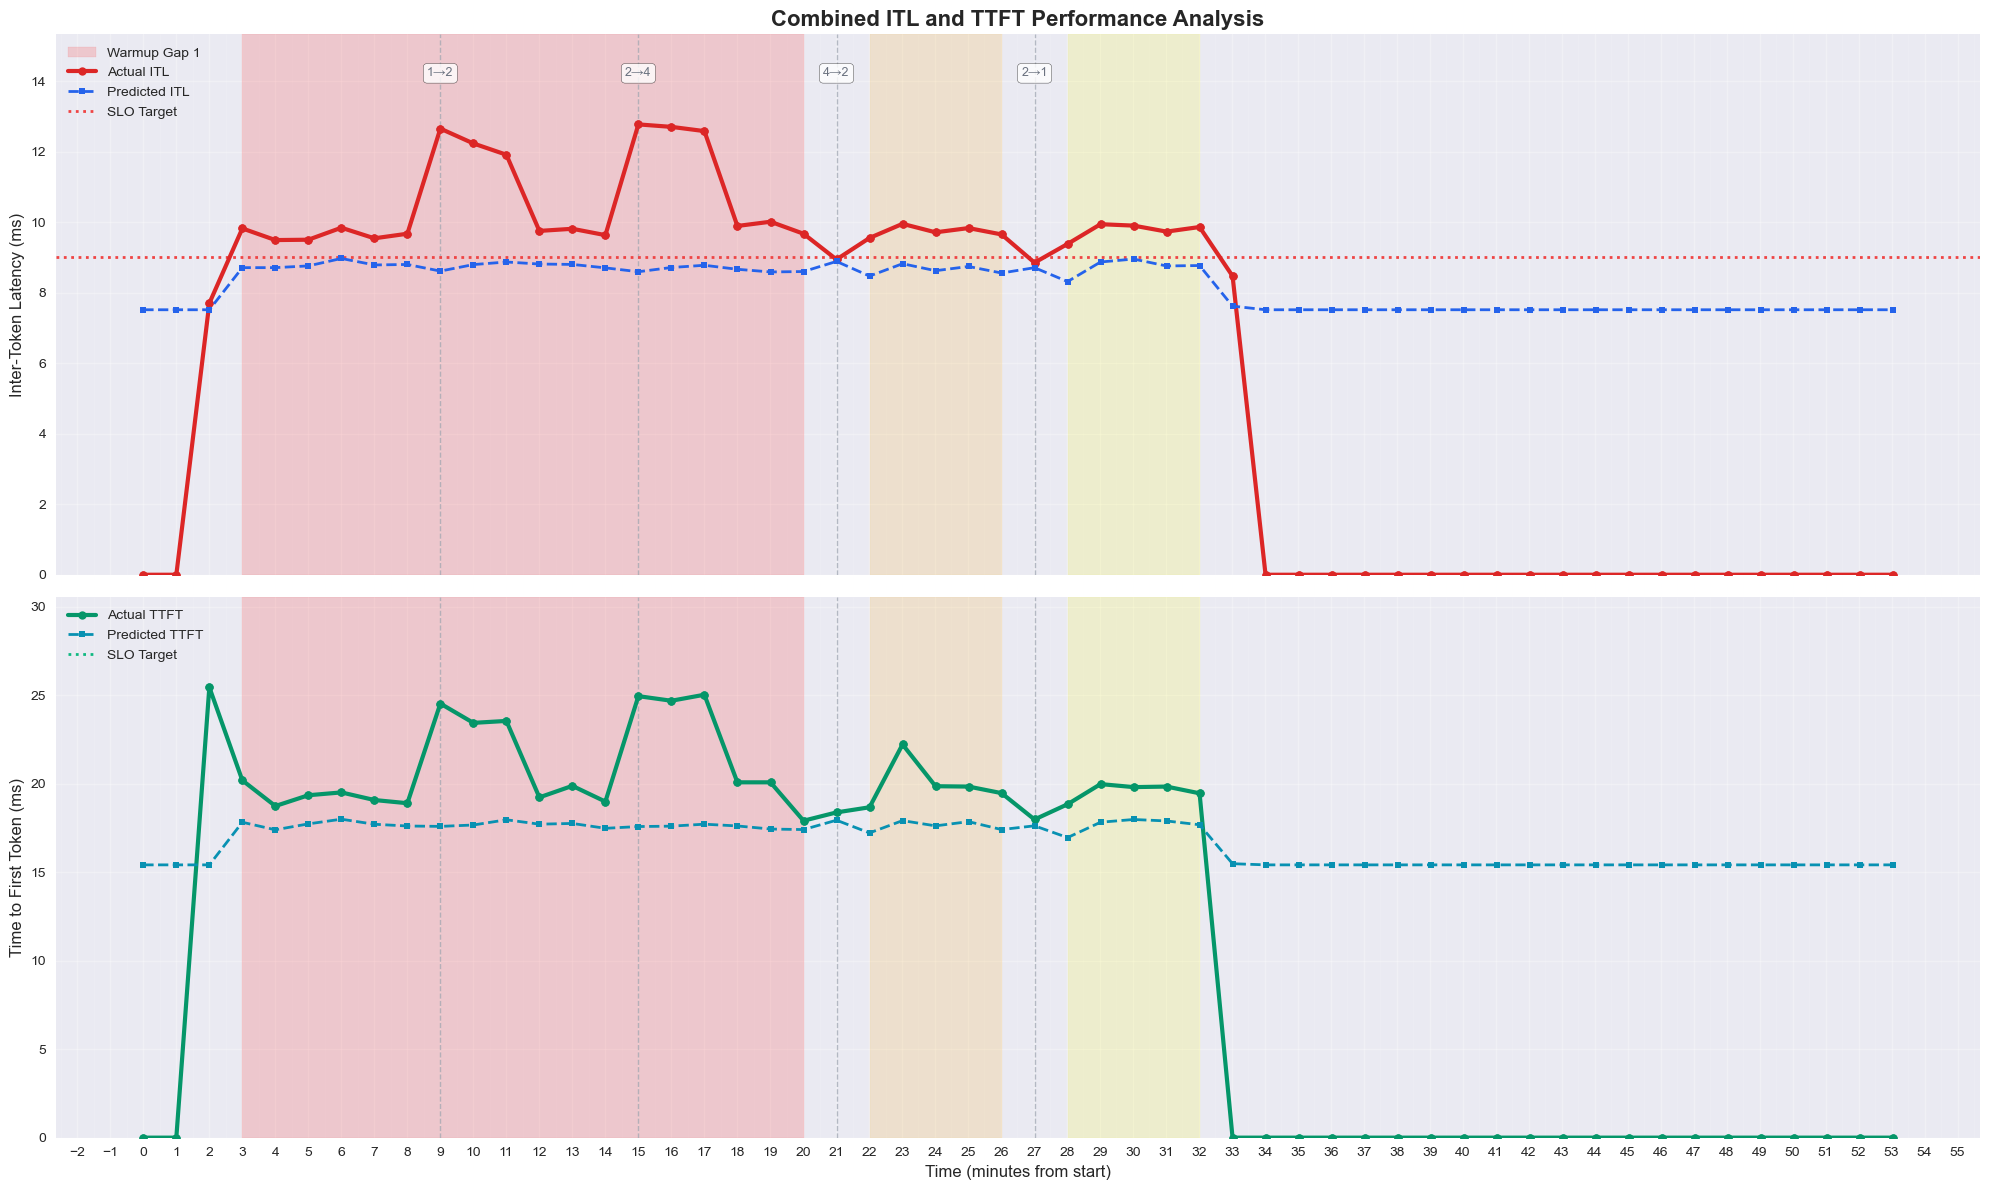

✅ Plot saved as 'experiments/20251020_150851/plots/combined_itl_ttft.png'


In [106]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), sharex=True)

# ITL subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['itlAverage'].max() * 1.2,
        alpha=0.15,
        color=color,
        label=f"Warmup Gap {i+1}" if i == 0 else ""
    )
    ax1.add_patch(rect)

ax1.plot(df['time_minutes'], df['itlAverage'], 'o-', 
         linewidth=3, markersize=6, color='#dc2626', label='Actual ITL', zorder=3)
ax1.plot(df['time_minutes'], df['itl'], 's--', 
         linewidth=2, markersize=4, color='#2563eb', label='Predicted ITL', zorder=3)
ax1.axhline(y=df['slo_itl'].iloc[0], color='#ef4444', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax1.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)
    ax1.text(event['time'], df['itlAverage'].max() * 1.1, 
             f"{event['from_replicas']:.0f}→{event['to_replicas']:.0f}",
             ha='center', va='bottom', fontsize=9, color='#6b7280',
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

ax1.set_ylabel('Inter-Token Latency (ms)', fontsize=12)
ax1.set_title('Combined ITL and TTFT Performance Analysis', fontweight='bold', fontsize=16)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, df['itlAverage'].max() * 1.2)

# TTFT subplot
for i, gap in enumerate(warmup_gaps):
    color = ['red', 'orange', 'yellow'][i % 3]
    rect = Rectangle(
        (gap['start_time'], 0),
        gap['end_time'] - gap['start_time'],
        df['ttftAverage'].max() * 1.2,
        alpha=0.15,
        color=color
    )
    ax2.add_patch(rect)

ax2.plot(df['time_minutes'], df['ttftAverage'], 'o-', 
         linewidth=3, markersize=6, color='#059669', label='Actual TTFT', zorder=3)
ax2.plot(df['time_minutes'], df['ttft'], 's--', 
         linewidth=2, markersize=4, color='#0891b2', label='Predicted TTFT', zorder=3)
ax2.axhline(y=df['slo_ttft'].iloc[0], color='#10b981', 
            linestyle=':', linewidth=2, label='SLO Target', zorder=2)

for event in scaling_events:
    ax2.axvline(x=event['time'], color='#9ca3af', linestyle='--', alpha=0.7, linewidth=1, zorder=1)

ax2.set_xlabel('Time (minutes from start)', fontsize=12)
ax2.set_ylabel('Time to First Token (ms)', fontsize=12)
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, df['ttftAverage'].max() * 1.2)

# Set x-axis granularity (applies to both subplots since sharex=True)
ax2.xaxis.set_major_locator(MultipleLocator(X_MAJOR_TICK_INTERVAL))
ax2.xaxis.set_minor_locator(MultipleLocator(X_MINOR_TICK_INTERVAL))
ax1.grid(True, which='major', alpha=0.3, linewidth=1)
ax1.grid(True, which='minor', alpha=0.15, linewidth=0.5)
ax2.grid(True, which='major', alpha=0.3, linewidth=1)
ax2.grid(True, which='minor', alpha=0.15, linewidth=0.5)

plt.tight_layout()
plot_path = f'{EXPERIMENT_DIR}/plots/combined_itl_ttft.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Plot saved as '{plot_path}'")

## 10. Visualization: Combined ITL & TTFT Analysis

## 11. Statistical Analysis

In [107]:
print("="*60)
print("WVA PERFORMANCE ANALYSIS SUMMARY")
print("="*60)
print(f"\n📊 Experiment Overview:")
print(f"   Experiment ID: {EXPERIMENT_NAME}")
print(f"   Duration: {df['time_minutes'].max():.1f} minutes")
print(f"   Data points: {len(df)}")
print(f"   Scaling pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas")
print(f"   Peak load: {df['rate'].max():.0f} rpm")
print(f"   SLO ITL: {df['slo_itl'].iloc[0]:.0f} ms")
print(f"   SLO TTFT: {df['slo_ttft'].iloc[0]:.0f} ms")

print(f"\n⚠️  Warmup Gap Analysis:")
for i, gap in enumerate(warmup_gaps, 1):
    print(f"\n   Gap {i} (t={gap['start_time']:.1f}-{gap['end_time']:.1f}min):")
    print(f"      Duration: {gap['duration']:.1f} minutes")
    print(f"      Peak ITL violation: {gap['peak_violation']:.2f} ms")
    print(f"      Average ITL: {gap['avg_tpot']:.2f} ms")
    print(f"      Average load: {gap['avg_load']:.0f} rpm")
    print(f"      SLO exceedance: {gap['avg_tpot'] - df['slo_itl'].iloc[0]:.2f} ms")

print(f"\n📈 ITL Performance Metrics:")
print(f"   Mean ITL: {df['itlAverage'].mean():.2f} ms")
print(f"   Median ITL: {df['itlAverage'].median():.2f} ms")
print(f"   Peak ITL: {df['itlAverage'].max():.2f} ms")
print(f"   Min ITL: {df['itlAverage'].min():.2f} ms")
print(f"   Std Dev: {df['itlAverage'].std():.2f} ms")

print(f"\n📈 TTFT Performance Metrics:")
print(f"   Mean TTFT: {df['ttftAverage'].mean():.2f} ms")
print(f"   Median TTFT: {df['ttftAverage'].median():.2f} ms")
print(f"   Peak TTFT: {df['ttftAverage'].max():.2f} ms")
print(f"   Min TTFT: {df['ttftAverage'].min():.2f} ms")
print(f"   Std Dev: {df['ttftAverage'].std():.2f} ms")

# SLO compliance
itl_violations = df[df['itlAverage'] > df['slo_itl']]
ttft_violations = df[df['ttftAverage'] > df['slo_ttft']]
itl_compliance_rate = (1 - len(itl_violations) / len(df)) * 100
ttft_compliance_rate = (1 - len(ttft_violations) / len(df)) * 100

print(f"\n✅ SLO Compliance:")
print(f"   ITL Compliance: {itl_compliance_rate:.1f}%")
print(f"   ITL Violations: {len(itl_violations)} / {len(df)} data points")
print(f"   TTFT Compliance: {ttft_compliance_rate:.1f}%")
print(f"   TTFT Violations: {len(ttft_violations)} / {len(df)} data points")

print(f"\n🔄 Scaling Events:")
for i, event in enumerate(scaling_events, 1):
    print(f"   {i}. t={event['time']:.1f}min: {event['from_replicas']:.0f} → {event['to_replicas']:.0f} replicas (load: {event['load']:.1f} rpm)")

print("\n" + "="*60)

# Save summary to file
summary_path = f'{EXPERIMENT_DIR}/analysis/summary.txt'
with open(summary_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("WVA PERFORMANCE ANALYSIS SUMMARY\n")
    f.write("="*60 + "\n")
    f.write(f"\nExperiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"ITL Compliance: {itl_compliance_rate:.1f}%\n")
    f.write(f"TTFT Compliance: {ttft_compliance_rate:.1f}%\n")
    f.write(f"Peak Load: {df['rate'].max():.0f} rpm\n")
    f.write(f"Scaling Pattern: {df['numRep'].min():.0f} → {df['numRep'].max():.0f} replicas\n")

print(f"\n✅ Summary saved to '{summary_path}'")

WVA PERFORMANCE ANALYSIS SUMMARY

📊 Experiment Overview:
   Experiment ID: 20251020_150851
   Duration: 53.0 minutes
   Data points: 108
   Scaling pattern: 1 → 4 replicas
   Peak load: 1690 rpm
   SLO ITL: 9 ms
   SLO TTFT: 1000 ms

⚠️  Warmup Gap Analysis:

   Gap 1 (t=3.0-20.0min):
      Duration: 17.0 minutes
      Peak ITL violation: 12.77 ms
      Average ITL: 10.64 ms
      Average load: 957 rpm
      SLO exceedance: 1.64 ms

   Gap 2 (t=22.0-26.0min):
      Duration: 4.0 minutes
      Peak ITL violation: 9.95 ms
      Average ITL: 9.74 ms
      Average load: 799 rpm
      SLO exceedance: 0.74 ms

   Gap 3 (t=28.0-32.0min):
      Duration: 4.0 minutes
      Peak ITL violation: 9.94 ms
      Average ITL: 9.76 ms
      Average load: 412 rpm
      SLO exceedance: 0.76 ms

📈 ITL Performance Metrics:
   Mean ITL: 5.98 ms
   Median ITL: 9.44 ms
   Peak ITL: 12.77 ms
   Min ITL: 0.00 ms
   Std Dev: 5.07 ms

📈 TTFT Performance Metrics:
   Mean TTFT: 11.81 ms
   Median TTFT: 18.70 ms
   

## 12. Export Results

Export the processed data and analysis results for further use.

In [108]:
# Export processed data with phases
processed_csv = f'{EXPERIMENT_DIR}/data/processed_metrics.csv'
df.to_csv(processed_csv, index=False)
print(f"✅ Processed data exported to '{processed_csv}'")

# Export warmup gaps analysis
if warmup_gaps:
    gaps_df = pd.DataFrame(warmup_gaps)
    gaps_csv = f'{EXPERIMENT_DIR}/analysis/warmup_gaps.csv'
    gaps_df.to_csv(gaps_csv, index=False)
    print(f"✅ Warmup gaps analysis exported to '{gaps_csv}'")

# Export scaling events
if scaling_events:
    events_df = pd.DataFrame(scaling_events)
    events_csv = f'{EXPERIMENT_DIR}/analysis/scaling_events.csv'
    events_df.to_csv(events_csv, index=False)
    print(f"✅ Scaling events exported to '{events_csv}'")

# Copy original log file to experiment directory
import shutil
log_copy = f'{EXPERIMENT_DIR}/data/original_log.txt'
shutil.copy(LOG_FILE, log_copy)
print(f"✅ Original log file copied to '{log_copy}'")

# Create experiment manifest
manifest_path = f'{EXPERIMENT_DIR}/manifest.txt'
with open(manifest_path, 'w') as f:
    f.write(f"Experiment ID: {EXPERIMENT_NAME}\n")
    f.write(f"Created: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Log File: {LOG_FILE}\n")
    f.write(f"Duration: {df['time_minutes'].max():.1f} minutes\n")
    f.write(f"Data Points: {len(df)}\n")
    f.write(f"\nDirectory Structure:\n")
    f.write(f"  - data/: Raw and processed data files\n")
    f.write(f"  - plots/: Generated visualization plots\n")
    f.write(f"  - analysis/: Statistical analysis results\n")
    
print(f"✅ Manifest created at '{manifest_path}'")
print(f"\n📁 Experiment directory: {EXPERIMENT_DIR}")
print(f"   All outputs have been organized in subdirectories")

✅ Processed data exported to 'experiments/20251020_150851/data/processed_metrics.csv'
✅ Warmup gaps analysis exported to 'experiments/20251020_150851/analysis/warmup_gaps.csv'
✅ Scaling events exported to 'experiments/20251020_150851/analysis/scaling_events.csv'
✅ Original log file copied to 'experiments/20251020_150851/data/original_log.txt'
✅ Manifest created at 'experiments/20251020_150851/manifest.txt'

📁 Experiment directory: experiments/20251020_150851
   All outputs have been organized in subdirectories


## 13. Custom Analysis (Optional)

Use this cell for custom queries and exploration.

In [109]:
# Example: Find periods where predicted ITL underestimated actual ITL
itl_underestimation = df[df['itlAverage'] > df['itl']]
print("ITL Controller Underestimation Analysis:")
print(f"Occurred in {len(itl_underestimation)} / {len(df)} samples ({len(itl_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(itl_underestimation['itlAverage'] - itl_underestimation['itl']).mean():.2f} ms")

# Show samples with largest ITL underestimation
print("\nTop 5 largest ITL underestimations:")
itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']
display(itl_underestimation.nlargest(5, 'gap')[['time_minutes', 'itlAverage', 'itl', 'gap', 'numRep', 'rate']])

# Example: Find periods where predicted TTFT underestimated actual TTFT
ttft_underestimation = df[df['ttftAverage'] > df['ttft']]
print("\nTTFT Controller Underestimation Analysis:")
print(f"Occurred in {len(ttft_underestimation)} / {len(df)} samples ({len(ttft_underestimation)/len(df)*100:.1f}%)")
print(f"Average underestimation: {(ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']).mean():.2f} ms")

# Show samples with largest TTFT underestimation
print("\nTop 5 largest TTFT underestimations:")
ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']
display(ttft_underestimation.nlargest(5, 'gap')[['time_minutes', 'ttftAverage', 'ttft', 'gap', 'numRep', 'rate']])

ITL Controller Underestimation Analysis:
Occurred in 64 / 108 samples (59.3%)
Average underestimation: 1.44 ms

Top 5 largest ITL underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_92417/201466315.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  itl_underestimation['gap'] = itl_underestimation['itlAverage'] - itl_underestimation['itl']


,time_minutes,itlAverage,itl,gap,numRep,rate
30,15.008200,12.77,8.592541,4.177459,4,1573.76
31,15.008617,12.77,8.592541,4.177459,4,1573.76
18,9.005017,12.65,8.610526,4.039474,2,803.88
19,9.005400,12.65,8.610526,4.039474,2,803.88
32,16.008767,12.70,8.712183,3.987817,4,1666.95



TTFT Controller Underestimation Analysis:
Occurred in 62 / 108 samples (57.4%)
Average underestimation: 2.99 ms

Top 5 largest TTFT underestimations:


/var/folders/w8/8n63220d7qnd2nmdqckjtls40000gn/T/ipykernel_92417/201466315.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ttft_underestimation['gap'] = ttft_underestimation['ttftAverage'] - ttft_underestimation['ttft']


,time_minutes,ttftAverage,ttft,gap,numRep,rate
4,2.001433,25.45,15.415337,10.034663,1,0.00
5,2.002083,25.45,15.415337,10.034663,1,0.00
30,15.008200,24.95,17.581606,7.368394,4,1573.76
31,15.008617,24.95,17.581606,7.368394,4,1573.76
34,17.009250,25.03,17.714722,7.315278,4,1689.79


## 14. Experiment Summary

Review the complete experiment directory structure and outputs.

In [110]:
import os
from pathlib import Path

print("="*70)
print(f"EXPERIMENT {EXPERIMENT_NAME} - COMPLETE")
print("="*70)

print(f"\n📁 Experiment Directory: {EXPERIMENT_DIR}")
print("\nDirectory Structure:")

# Walk through the experiment directory
for root, dirs, files in os.walk(EXPERIMENT_DIR):
    level = root.replace(EXPERIMENT_DIR, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        file_path = os.path.join(root, file)
        file_size = os.path.getsize(file_path)
        print(f'{subindent}📄 {file} ({file_size:,} bytes)')

print("\n" + "="*70)
print("Generated Outputs:")
print("="*70)

print("\n📊 Plots (6 visualizations):")
print("   1. itl_analysis.png - ITL performance with warmup gaps")
print("   2. ttft_analysis.png - TTFT performance with warmup gaps")
print("   3. load_pattern.png - Arrival rate evolution")
print("   4. itl_replicas_timeline.png - ITL vs replica scaling")
print("   5. ttft_replicas_timeline.png - TTFT vs replica scaling")
print("   6. combined_itl_ttft.png - Combined ITL & TTFT analysis")

print("\n📈 Data Files:")
print("   • extracted_metrics.csv - Raw extracted metrics")
print("   • processed_metrics.csv - Processed data with time calculations")
print("   • original_log.txt - Copy of original log file")

print("\n📋 Analysis Files:")
print("   • warmup_gaps.csv - Detected warmup gap statistics")
print("   • scaling_events.csv - Scaling event log")
print("   • summary.txt - Text summary of key findings")

print("\n📝 Experiment Metadata:")
print("   • manifest.txt - Experiment configuration and metadata")

print("\n" + "="*70)
print(f"✅ All outputs saved to: {EXPERIMENT_DIR}")
print("="*70)

EXPERIMENT 20251020_150851 - COMPLETE

📁 Experiment Directory: experiments/20251020_150851

Directory Structure:
20251020_150851/
  📄 manifest.txt (304 bytes)
  📄 extracted_metrics.csv (7,733 bytes)
  analysis/
    📄 summary.txt (310 bytes)
    📄 warmup_gaps.csv (324 bytes)
    📄 scaling_events.csv (155 bytes)
  data/
    📄 processed_metrics.csv (10,708 bytes)
    📄 original_log.txt (606,112 bytes)
  plots/
    📄 itl_analysis.png (372,332 bytes)
    📄 ttft_replicas_timeline.png (230,101 bytes)
    📄 itl_replicas_timeline.png (335,198 bytes)
    📄 combined_itl_ttft.png (539,705 bytes)
    📄 load_pattern.png (244,870 bytes)
    📄 ttft_analysis.png (376,708 bytes)

Generated Outputs:

📊 Plots (6 visualizations):
   1. itl_analysis.png - ITL performance with warmup gaps
   2. ttft_analysis.png - TTFT performance with warmup gaps
   3. load_pattern.png - Arrival rate evolution
   4. itl_replicas_timeline.png - ITL vs replica scaling
   5. ttft_replicas_timeline.png - TTFT vs replica scaling